In [30]:
# # Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


# Data Engineering

In [31]:
data_path = "data/task1/jetnet_logs.txt"

f = open(data_path, "r")
lines = f.readlines()
len(lines)

87192

In [32]:
def split_lines(line):
    ind = line[1:].find('@')
    if ind == -1:
        return [line]
    else:
        ind += 1
        return [line[:ind]] + split_lines(line[ind:])

lines2 = []
for line in lines:
    for l in split_lines(line):
        lines2.append(l)
    
lines = lines2
len(lines)

87572

In [33]:
import re
from datetime import datetime

def parse(log):
    name = log.split()[0][:-1]
    log = log[len(name) + 2:]
    log = re.split('-+>', log)
    
    actions = []
    
    for s in log:
        s = s.strip()
        if (len(s) > 0):
            action_name = s.split()[0]
            time = s[len(action_name):].strip()
            if time[0] != '(':
                time = '(' + time
            if time == "(null)" or action_name == 'END':
                continue
            
            time = datetime.strptime(time.strip(), '(%d/%m/%y | %H:%M:%S)')
            actions.append((action_name, time))
    return name, actions

In [34]:
parsed = list(map(parse, lines))
parsed = list(filter(lambda x: len(x[1]) > 0, parsed))
len(parsed)

86400

In [35]:
parsed = sorted(parsed, key = lambda x: x[1][0][1])

In [36]:
parsed[-1]

('@User126',
 [('Action_3', datetime.datetime(2021, 9, 19, 1, 51, 17)),
  ('Action_1', datetime.datetime(2021, 9, 19, 2, 41, 16)),
  ('Action_6', datetime.datetime(2021, 9, 19, 3, 16, 51)),
  ('Action_7', datetime.datetime(2021, 9, 19, 4, 10, 22)),
  ('Action_8', datetime.datetime(2021, 9, 19, 4, 57, 11)),
  ('Action_4', datetime.datetime(2021, 9, 19, 5, 0, 36)),
  ('Action_8', datetime.datetime(2021, 9, 19, 5, 0, 55)),
  ('Action_7', datetime.datetime(2021, 9, 19, 5, 19, 29)),
  ('Action_4', datetime.datetime(2021, 9, 19, 5, 42, 19)),
  ('Action_6', datetime.datetime(2021, 9, 19, 5, 31, 9)),
  ('Action_8', datetime.datetime(2021, 9, 19, 7, 7, 6)),
  ('Action_8', datetime.datetime(2021, 9, 19, 7, 53, 42)),
  ('Action_3', datetime.datetime(2021, 9, 19, 8, 8, 16)),
  ('Action_4', datetime.datetime(2021, 9, 19, 8, 47, 5)),
  ('Action_10', datetime.datetime(2021, 9, 19, 9, 11, 52)),
  ('Action_3', datetime.datetime(2021, 9, 19, 9, 44, 47))])

In [37]:
!pip install pandas

In [38]:
import pandas as pd

session_num = dict()

user_id_col = []
session_num_col = []
action_time_col = []
action_name_col = []

for (name, actions) in parsed:
    curr_session = 0
    if name in session_num:
        curr_session = session_num[name] + 1
    session_num[name] = curr_session
    
    for (action_name, time) in actions:
        user_id_col.append(name)
        session_num_col.append(curr_session)
        action_time_col.append(time)
        action_name_col.append(action_name)

df = pd.DataFrame({'user_id' : user_id_col, 
                   'session_num' : session_num_col, 
                   'action_time' : action_time_col, 
                   'action_name': action_name_col})

df

,user_id,session_num,action_time,action_name
0,@User122,0,2019-09-20 13:44:16,Action_7
1,@User103,0,2019-09-20 13:45:07,Action_7
2,@User103,0,2019-09-20 14:28:28,Action_7
3,@User103,0,2019-09-20 14:27:15,Action_4
4,@User103,0,2019-09-20 14:27:19,Action_4
...,...,...,...,...
1972987,@User126,1036,2021-09-19 07:53:42,Action_8
1972988,@User126,1036,2021-09-19 08:08:16,Action_3
1972989,@User126,1036,2021-09-19 08:47:05,Action_4
1972990,@User126,1036,2021-09-19 09:11:52,Action_10


# Metrics Evaluation

Mean actions count per user overall

In [60]:
df['user_id'].value_counts().mean()

13797.146853146853

Mean actions by user in a day

In [61]:
from pandas import Timestamp

In [62]:
df2 = df[['user_id', 'action_time']].copy()
df2['action_time'] = df2['action_time'].apply(Timestamp.date)
df2

,user_id,action_time
0,@User122,2019-09-20
1,@User103,2019-09-20
2,@User103,2019-09-20
3,@User103,2019-09-20
4,@User103,2019-09-20
...,...,...
1972987,@User126,2021-09-19
1972988,@User126,2021-09-19
1972989,@User126,2021-09-19
1972990,@User126,2021-09-19


In [63]:
df2.groupby(['user_id', 'action_time']).size().mean()

28.616897527014288

The probability of repeating the same action three times in a row during one session

In [12]:
from tqdm.notebook import tqdm

In [294]:
count = 0
for _, group in tqdm(df.groupby(['user_id', 'session_num'])):
    group = group.sort_values('action_time')
    
    if any((group['action_name'] == val).rolling(3).sum().max() == 3 for val in group['action_name'].unique()):
        count += 1

print(count) 

  0%|          | 0/86400 [00:00<?, ?it/s]

28113


In [295]:
count_all = df.groupby(['user_id', 'session_num']).ngroups

In [296]:
count / count_all

0.32538194444444446

The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one sessio

In [13]:
import numpy as np

deltas = []

df2 = df.sort_values('action_time')

for _, group in tqdm(df2.groupby(['user_id', 'session_num', 'action_name'])):
    
    deltas += list((group['action_time'].diff().to_numpy()[1:] / 1e9).astype(int))
        
deltas= np.array(deltas).astype(int)

  0%|          | 0/674143 [00:00<?, ?it/s]

In [16]:
deltas.shape

(1298849,)

In [37]:
!pip install matplotlib

                                              0.0/7.6 MB ? eta -:--:--
                                              0.1/7.6 MB 2.8 MB/s eta 0:00:03
     --                                       0.5/7.6 MB 4.7 MB/s eta 0:00:02
     ---                                      0.7/7.6 MB 5.1 MB/s eta 0:00:02
     -----                                    1.0/7.6 MB 5.1 MB/s eta 0:00:02
     ------                                   1.3/7.6 MB 5.9 MB/s eta 0:00:02
     --------                                 1.5/7.6 MB 5.7 MB/s eta 0:00:02
     ----------                               2.0/7.6 MB 6.3 MB/s eta 0:00:01
     ------------                             2.4/7.6 MB 6.6 MB/s eta 0:00:01
     -------------                            2.6/7.6 MB 6.5 MB/s eta 0:00:01
     ---------------                          3.0/7.6 MB 6.3 MB/s eta 0:00:01
     -----------------                        3.3/7.6 MB 6.5 MB/s eta 0:00:01
     -------------------                      3.7/7.6 MB 6.5 MB/s eta 0

In [17]:
np.quantile(deltas, 0.95)

27505.0

Is there statistical difference of activity in different days of the week? And between weekends and workdays?

In [21]:
df2 = df[['action_time']].copy()
df2['action_time'] = df2['action_time'].dt.strftime('%A')
df2

,action_time
0,Friday
1,Friday
2,Friday
3,Friday
4,Friday
...,...
1972987,Sunday
1972988,Sunday
1972989,Sunday
1972990,Sunday


In [22]:
df2.groupby(['action_time']).size()

action_time
Friday       282295
Monday       276519
Saturday     284927
Sunday       283787
Thursday     280690
Tuesday      281341
Wednesday    283433
dtype: int64

Distribution of the activity during the day

In [27]:
hour_counts = df['action_time'].dt.hour.value_counts()
hour_counts.sort_index()

action_time
0     134071
1     134424
2     125824
3     116255
4     106062
5      95335
6      84912
7      73598
8      63422
9      54052
10     45282
11     36973
12     30183
13     30040
14     38473
15     48048
16     58925
17     69164
18     80086
19     90984
20    100029
21    110236
22    118943
23    127671
Name: count, dtype: int64

Distribution of different activity types

In [29]:
action_counts = df['action_name'].value_counts() / len(df)
action_counts

action_name
Action_7     0.235829
Action_3     0.158495
Action_4     0.130378
Action_10    0.127462
Action_0     0.078249
Action_1     0.073851
Action_6     0.072374
Action_8     0.062058
Action_9     0.037647
Action_5     0.013448
Action_2     0.009672
null         0.000536
Name: count, dtype: float64

# Data Visualisation

In [53]:
!pip install seaborn

                                              0.0/293.3 kB ? eta -:--:--
     --------------                         112.6/293.3 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 3.0 MB/s eta 0:00:00


In [86]:
import matplotlib.pyplot as plt

df2 = df[['action_time', 'action_name', 'user_id']].copy()
df2['action_time'] = df2['action_time'].dt.date
df2

,action_time,action_name,user_id
0,2019-09-20,Action_7,@User122
1,2019-09-20,Action_7,@User103
2,2019-09-20,Action_7,@User103
3,2019-09-20,Action_4,@User103
4,2019-09-20,Action_4,@User103
...,...,...,...
1972987,2021-09-19,Action_8,@User126
1972988,2021-09-19,Action_3,@User126
1972989,2021-09-19,Action_4,@User126
1972990,2021-09-19,Action_10,@User126


In [87]:
group_sizes = df2.groupby(['action_time', 'action_name']).count()['user_id']

In [88]:
group_sizes = group_sizes.reset_index()

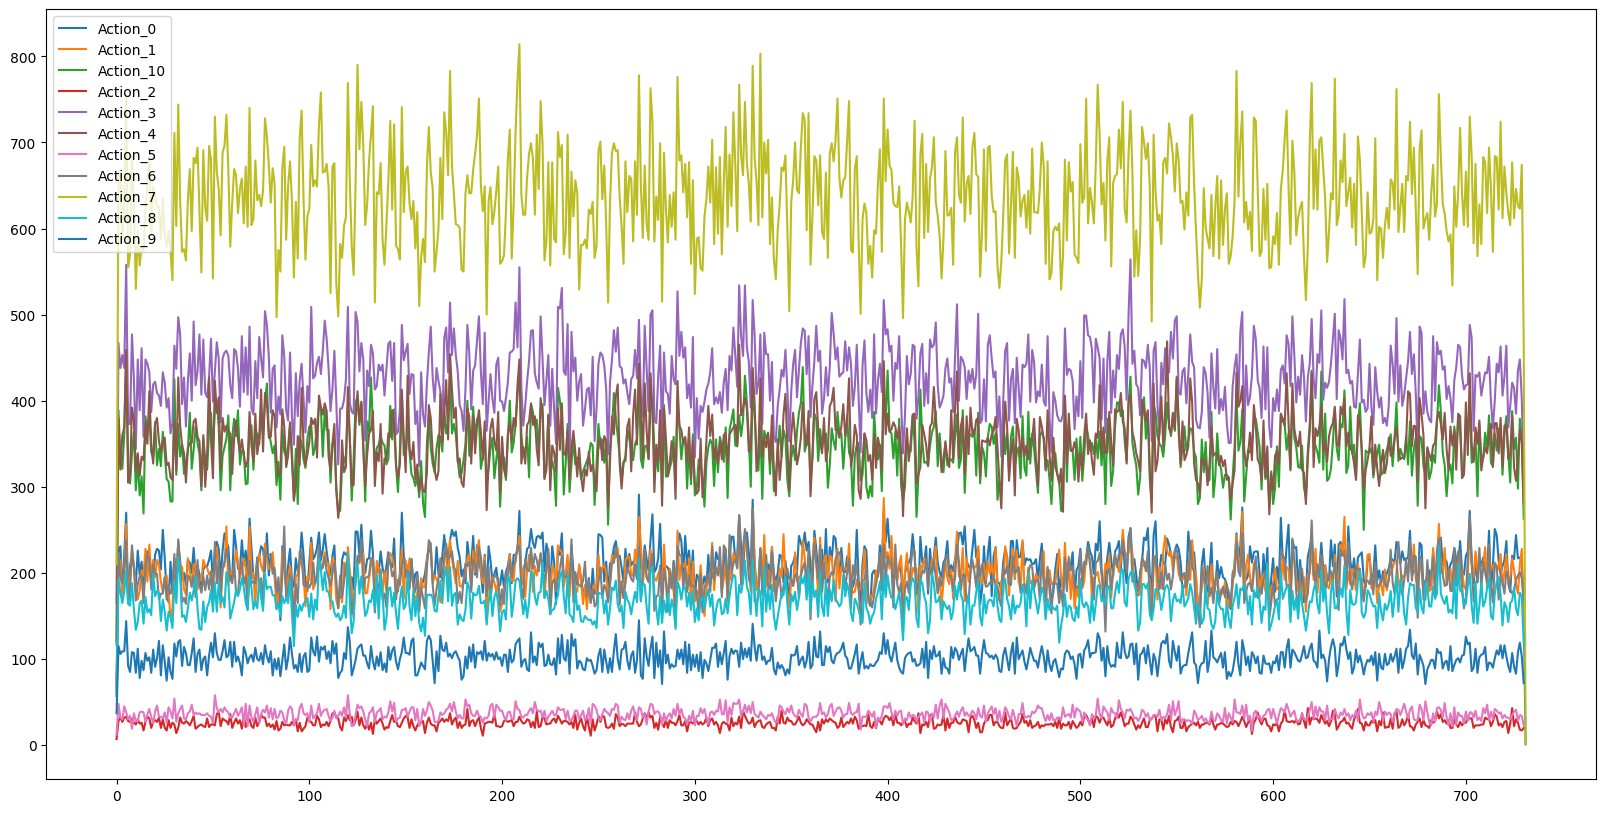

In [89]:
plt.figure(figsize=(20, 10))
for action_name in group_sizes.action_name.unique()[:-1]:
    cnts = group_sizes[group_sizes['action_name'] == action_name]['user_id'].to_numpy()
    plt.plot(cnts, label=action_name)

plt.legend()
plt.show()

In [100]:
cnts = group_sizes.groupby('action_name')['user_id'].sum().reset_index()
names = cnts['action_name'].to_numpy()
counts = cnts['user_id'].to_numpy()
names, counts

(array(['Action_0', 'Action_1', 'Action_10', 'Action_2', 'Action_3',
        'Action_4', 'Action_5', 'Action_6', 'Action_7', 'Action_8',
        'Action_9', 'null'], dtype=object),
 array([154385, 145708, 251482,  19082, 312710, 257235,  26532, 142794,
        465289, 122440,  74277,   1058], dtype=int64))

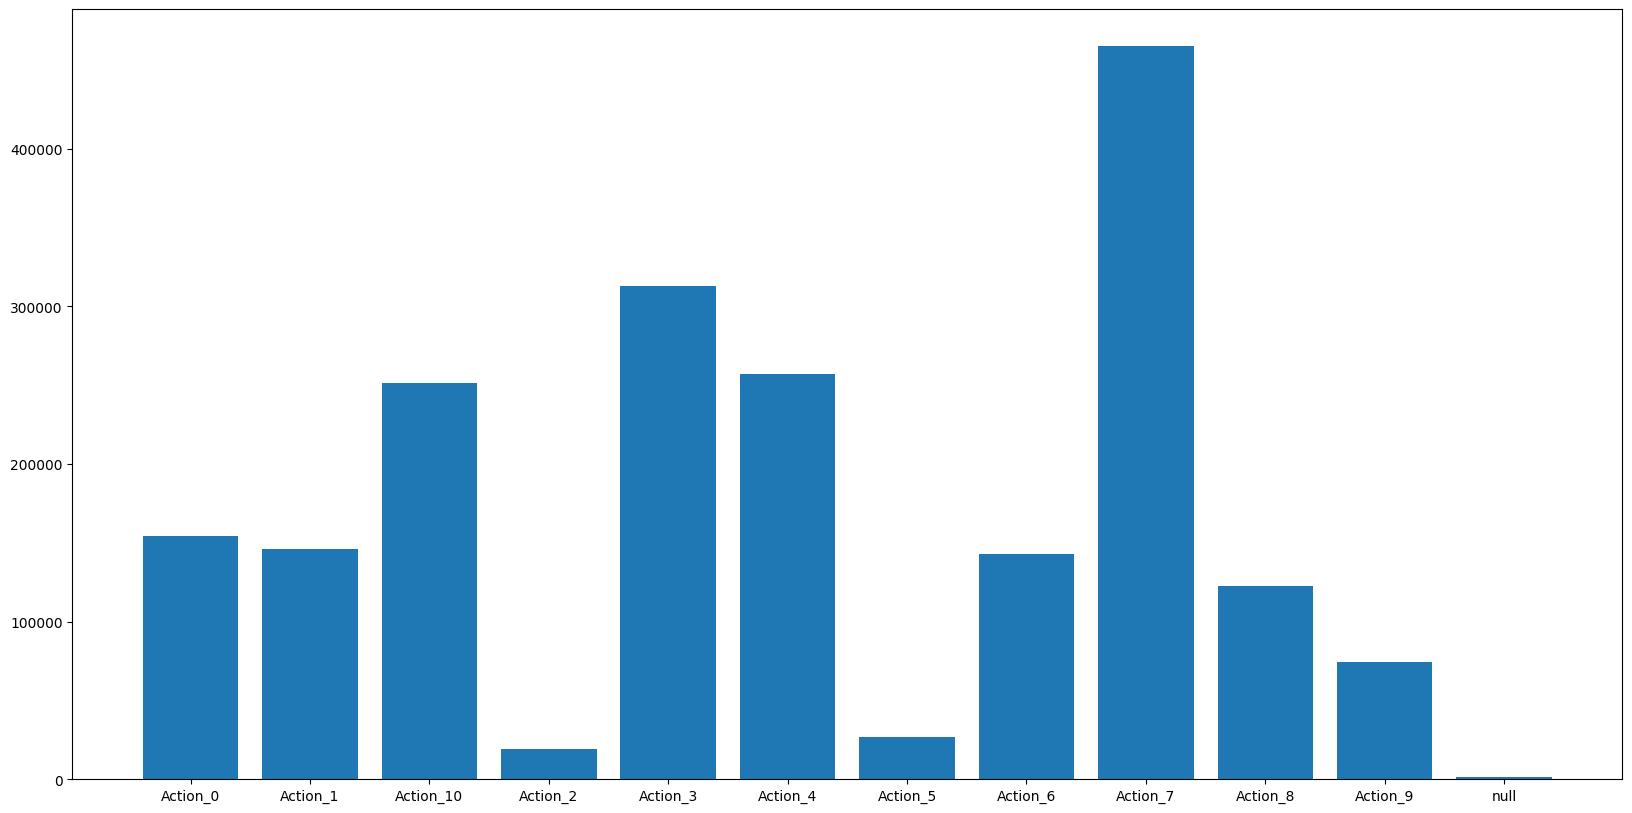

In [108]:
plt.figure(figsize=(20, 10))
plt.bar(x = names, height=counts)
plt.show()

In [119]:
from collections import defaultdict

cnts = defaultdict(int)


df2 = df[['session_num', 'user_id', 'action_name']]
for _, group in df2.groupby(['session_num', 'user_id'])['action_name']:
    names = group.to_numpy()
    for i in range(len(names) - 1):
        cnts[(names[i], names[i + 1])] += 1

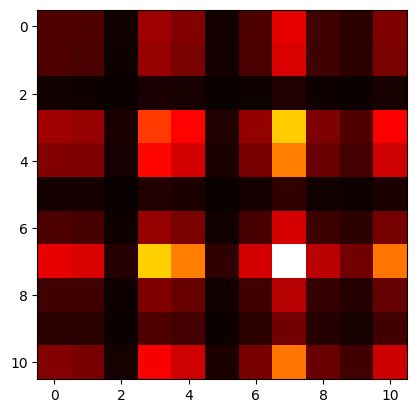

In [129]:
matr = np.zeros((11, 11))

for (key) in cnts:
    name1= key[0]
    name2= key[1]
    
    if name1 == 'null' or name2 == 'null':
        continue
    
    ind1 = int(name1[7:])
    ind2 = int(name2[7:])
    
    matr[ind1, ind2] = int(cnts[key])

plt.imshow(matr, cmap='hot')
plt.show()

In [139]:
users = df.user_id.value_counts()
top20users = users[:int(0.2 * len(users))].index

In [140]:
df2 = df[df['user_id'].isin(top20users)]

In [141]:
df2 = df2[['action_time', 'action_name', 'user_id']].copy()
df2['action_time'] = df2['action_time'].dt.date
df2

,action_time,action_name,user_id
36,2019-09-20,Action_3,@User118
37,2019-09-20,Action_7,@User118
38,2019-09-20,Action_10,@User118
39,2019-09-20,Action_7,@User118
40,2019-09-20,Action_7,@User118
...,...,...,...
1972987,2021-09-19,Action_8,@User126
1972988,2021-09-19,Action_3,@User126
1972989,2021-09-19,Action_4,@User126
1972990,2021-09-19,Action_10,@User126


In [142]:
group_sizes = df2.groupby(['action_time', 'action_name']).count()['user_id']

In [143]:
group_sizes = group_sizes.reset_index()

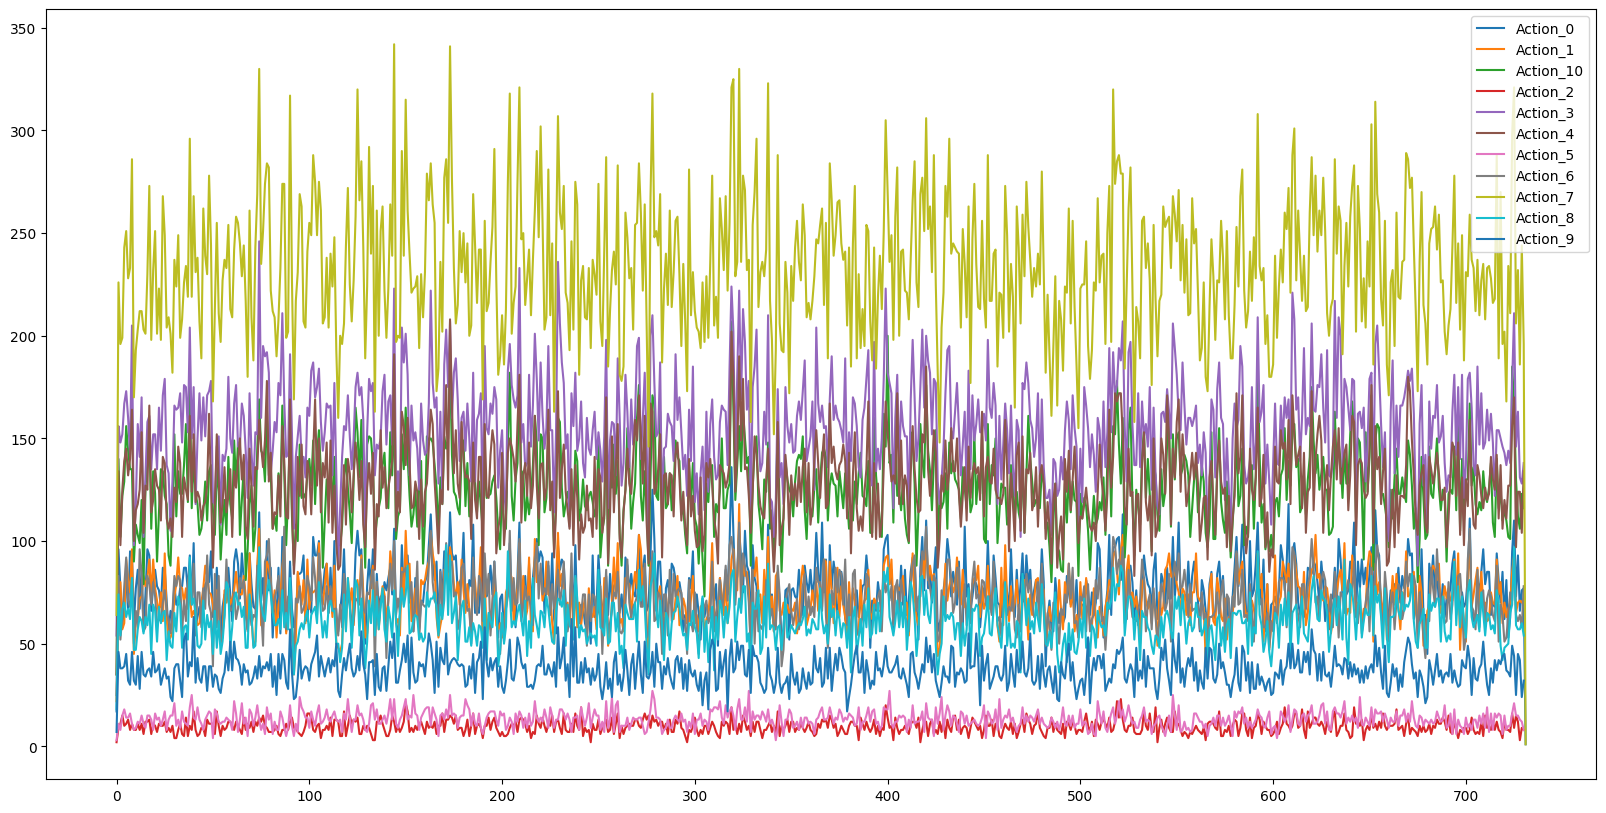

In [144]:
plt.figure(figsize=(20, 10))
for action_name in group_sizes.action_name.unique()[:-1]:
    cnts = group_sizes[group_sizes['action_name'] == action_name]['user_id'].to_numpy()
    plt.plot(cnts, label=action_name)

plt.legend()
plt.show()

activity level during the day

In [146]:
hour_counts = df['action_time'].dt.hour.value_counts()
hour_counts = hour_counts.sort_index()

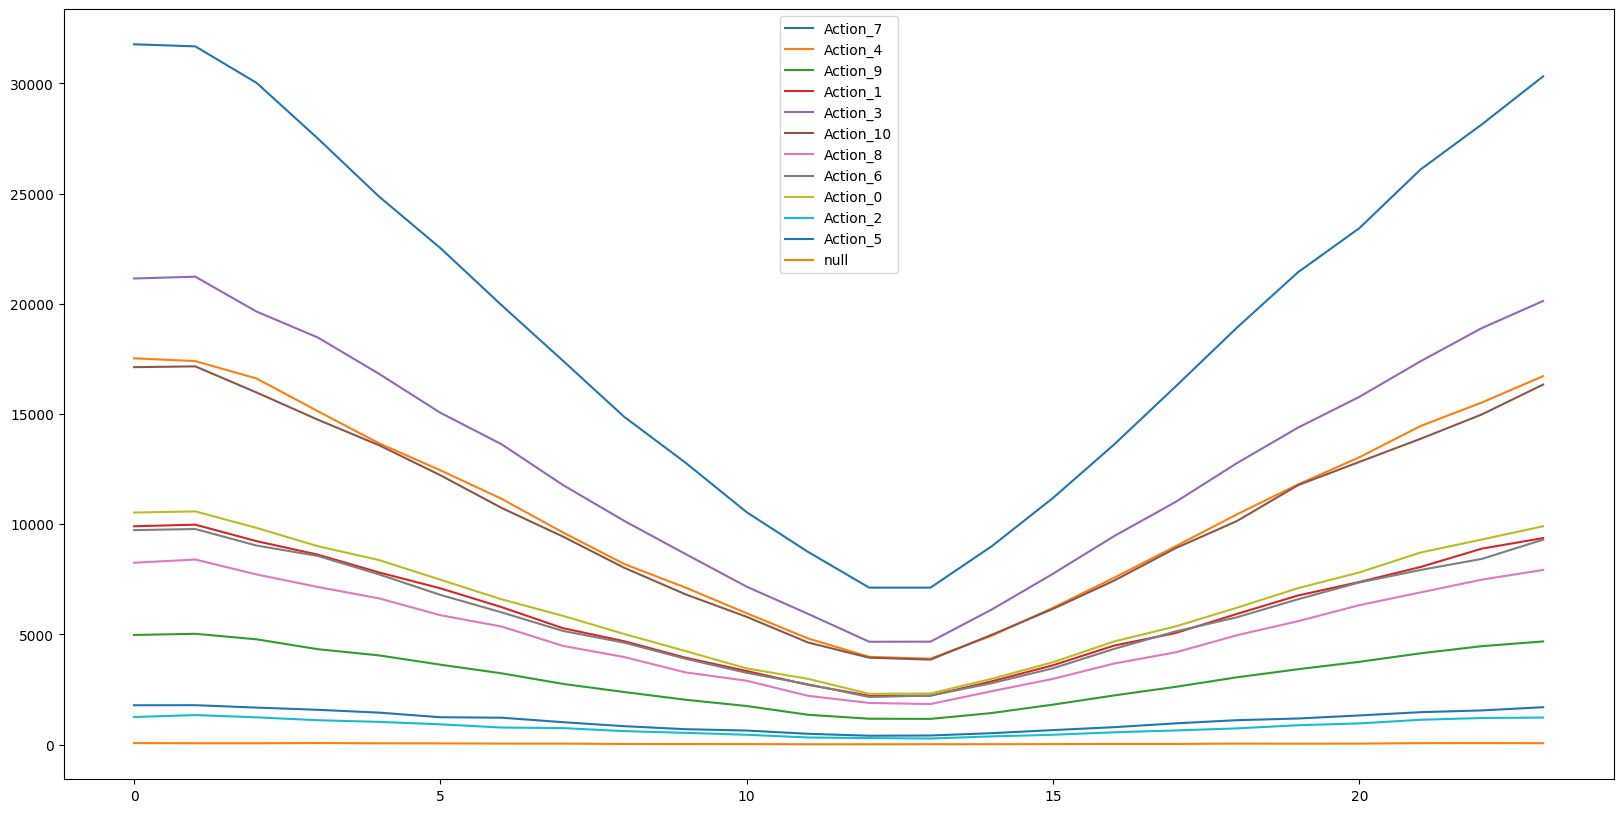

In [152]:
plt.figure(figsize=(20, 10))

for action_name in df.action_name.unique():
    hour_counts = df[df.action_name == action_name]['action_time'].dt.hour.value_counts()
    hour_counts = hour_counts.sort_index()
    plt.plot(hour_counts.to_numpy(), label=action_name)

plt.legend()
plt.show()